# I. Lý thuyết

1) Tại sao các mô hình deep learning lại chiếm ưu thế hơn so với các mô hình machine learning truyền thống đối với dữ liệu lớn ?

A. Do mô hình deep learning có thể được thiết kế với kích thước tùy ý nên có khả năng xấp xỉ mọi hàm số. Do đó nó có khả năng biểu diễn tốt và hoạt động hiệu quả trên dữ liệu lớn.

B. Các mô hình machine learning thường bị overfitting đối với dữ liệu lớn ?

C. Các mô hình deep learning có chi phí huấn luyện tốn kém hơn so với machine learning.

D. Do kiến trúc của mô hình Machine Learning bao gồm nhiều layers xếp chồng.

**Đáp án**: A

2) Ý nghĩa của hàm loss function trong mạng neural network là gì ?

A. Là hàm số đánh giá độ chính xác của mô hình.

B. Mục tiêu của quá trình huấn luyện là tối thiểu hóa hàm loss function bằng thuật toán gradient descent. Giá trị của hàm số này giúp đo lường mức độ khớp của dự báo từ mô hình trên dữ liệu huấn luyện.

C. Khi loss function giảm thì luôn đảm bảo độ chính xác của mô hình tăng.

D. Là hàm số cần tối đa hóa trong quá trình huấn luyện.

**Đáp án**: B

3) Khi huấn luyện trên các bộ dữ liệu bigdata thì chúng ta nên sử dụng phương pháp nào ?

A) Sử dụng gradient descent trên toàn bộ dữ liệu.

B) Sử dụng stochastic gradient descent trên từng điểm dữ liệu.

C) Mini-batch gradient descent huấn luyện mô hình trên từng tập dữ liệu con có kích thước nhỏ hơn memory CPU/GPU.

D) Có thể sử dụng stochastic gradient descent hoặc mini-batch gradient descent.

**Đáp án**: C

4) Quá trình feed forward và backpropagation thực hiện những gì ?

A) feed forward tính toán output và loss function, backpropagation tính đạo hàm trên từng layer và cập nhật trọng số.

B) feed forward cập nhật trọng số cho mô hình, backpropagation tính toán output và loss function.

C) feed forward tính ra output của mô hình, backpropagation tính toán loss function

D) feed forward được thực hiện sau backpropagation.

**Đáp án**: A

5) Tác dụng của batch normalization là gì ?

A) Loại bỏ một tỷ lệ ngẫu nhiên số lượng units tại mỗi layer để tạo thành nhiều kiến trúc kết hợp ngẫu nhiên.

B) Tìm ra các tham số phân phối là trung bình và phương sai trên từng mini-batch.

C) Đồng nhất phân phối xác suất của $z^{[l]}$ trên mỗi layer $l$.

D) Giảm thiểu ảnh hưởng của input distribution shift nhằm giúp huấn luyện loss function nhanh và ổn định hơn.

**Đáp án**: D

# II. Thực hành

Xuất phát từ mô hình tốt nhất của bạn xây dựng được đối với bài toán phân loại income classification tại bài trước. Bạn hãy thực hiện một số thử nghiệm sau:

6) Thay đổi hàm loss function, batch size và optimizer.

7) Thử nghiệm thêm các layers mà bạn đã học được trong bài này vào kiến trúc của mình.

8) Thay đổi các khởi tạo trọng số theo các phân phối khác nhau và đánh giá độ chính xác của kết quả huấn luyện.

9) Thiết lập không gian search và tự động hóa tìm kiếm kiến trúc tốt nhất trên optuna.

10) Deploy model sử dụng flask app. Tham khảo [Flaskapp tutorial](https://drive.google.com/file/d/1AZNtzrmnhJ-OBgijWoaAqXbPhJ6xL0Po/view?usp=sharing).

In [ ]:
from google.colab import drive
import os
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import random
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
seed = 42 
seed_all(seed)

In [ ]:
#metric
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred, digits=4), '\n')

In [ ]:
os.chdir("gdrive/MyDrive/Colab Notebooks/DeepLearning2/4.DeepNeuralNetwork")

In [ ]:
df_all = pd.read_csv('../data/income_classification/train.csv')

In [ ]:
# normalize string
def str_normalize(s):
    # convert into lowercase and replace multiple spaces into single space
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s
# Encode category and object columns 
def process(df):        
  for col in df.columns:
      if df[col].dtype.name == "object" or df[col].dtype.name == "category":
          df[col] = df[col].apply(str_normalize).astype("category")
  return df
df_all = process(df_all.copy())
IDs=df_all.pop('ID')
label = df_all.pop('target_income')
df_all_one_hot = pd.get_dummies(df_all)

In [ ]:
features = df_all_one_hot.columns.tolist()
label = label.values

In [ ]:
features = df_all_one_hot.columns.tolist()

x_train, x_test, y_train, y_test = train_test_split(df_all_one_hot[features].values, # input variable
                                                    label, # output variable
                                                    test_size=0.2, # test dataset proportion
                                                    # stratify=df_all['target_income'], # assign equal proportion of target label in train/test 
                                                    random_state=0) # keep train/test split the same if run again. 
print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
#normalize
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Training Set: 20000, Test Set: 5000 



In [ ]:
import pickle
def _save_pkl(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)
def _load_pkl(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj
_save_pkl('scaler.pkl', sc)

In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).float()
train_ds = td.TensorDataset(train_x,train_y)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).float()
test_ds = td.TensorDataset(test_x,test_y)
print('Ready to load data')

Ready to load data


Một số loss function, optimizer và batch size và layers bạn có thể lựa chọn:

* Loss function: MSE, L1, SmoothL1, KL - Divergence,...
* Optimizer: Adam, Ada, RMSProp
* Batch size: thay đổi 32, 64, ...
* Thêm đổi Layers: Batch Normalization (trước activation function), Dropout ở trước layer cuối
* Thay thế activation function: Sigmoid, Hardswish, ReLU, GELU, LeakyReLU,...

Độ chính xác của mô hình ngẫu nhiên bài trước đang là 84.5%.

# 7. Thiết lập kiến trúc cho mô hình bằng cách thêm/thay thế các layers mới.

In [ ]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.bn1 = nn.BatchNorm1d(hl)
        self.fc2 = nn.Linear(hl, hl)
        self.bn2 = nn.BatchNorm1d(hl)
        self.fc3 = nn.Linear(hl, 6)
        self.bn3 = nn.BatchNorm1d(6)
        self.drop = nn.Dropout(0.5)
        self.fc4 = nn.Linear(6, 1)
        self.acts = [nn.ReLU(), nn.ReLU(), nn.Sigmoid()] # can replace by other Activation Type

    def forward(self, x):
        x = self.acts[0](self.fc1(x))
        x = self.bn1(x)
        x = self.acts[1](self.fc2(x))
        x = self.bn2(x)
        x = self.acts[2](self.fc3(x))
        x = self.bn3(x)
        x = self.drop(x)
        x = torch.sigmoid(self.fc4(x))
        return x

# Create a model instance from the network
model = Model()
print(model)

Model(
  (fc1): Linear(in_features=108, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)


# 8. Thay đổi khởi tạo các trọng số

In [ ]:
from torch import nn
def init_weights(m, init_type = 'xavier'):
    if type(m) == nn.Linear:
      if init_type == 'xavier':
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'normal':
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'he':
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
model.apply(lambda m: init_weights(m, init_type = 'normal'))

Model(
  (fc1): Linear(in_features=108, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
def train(model, data_loader, optimizer):
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor

        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target.reshape(-1,1))
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target.reshape(-1,1)).item()

            # Calculate the accuracy
            predicted = [1 if i>0.5 else 0 for i in out.data]
            predicted = torch.tensor(predicted)

            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# 6. Thay đổi loss function, optimizer, batch_size

In [ ]:
train_loader = td.DataLoader(train_ds, batch_size=64,
    shuffle=True, num_workers=2)
test_loader = td.DataLoader(test_ds, batch_size=64,
    shuffle=False, num_workers=2)

* Sử dụng khởi tạo `he`

In [ ]:
model.apply(lambda m: init_weights(m, init_type = 'he'))

Model(
  (fc1): Linear(in_features=108, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
loss_criteria = nn.HuberLoss()
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
epoch_nums = []
training_loss = []
validation_loss = []
epochs = 30
for epoch in range(1, epochs + 1):
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.079367
Validation set: Average loss: 0.055173, Accuracy: 4216/5000 (84%)

Epoch: 2
Training set: Average loss: 0.060467
Validation set: Average loss: 0.053015, Accuracy: 4218/5000 (84%)

Epoch: 3
Training set: Average loss: 0.057347
Validation set: Average loss: 0.051779, Accuracy: 4231/5000 (85%)

Epoch: 4
Training set: Average loss: 0.056619
Validation set: Average loss: 0.051854, Accuracy: 4221/5000 (84%)

Epoch: 5
Training set: Average loss: 0.055304
Validation set: Average loss: 0.053225, Accuracy: 4223/5000 (84%)

Epoch: 6
Training set: Average loss: 0.054365
Validation set: Average loss: 0.051491, Accuracy: 4251/5000 (85%)

Epoch: 7
Training set: Average loss: 0.054531
Validation set: Average loss: 0.051377, Accuracy: 4244/5000 (85%)

Epoch: 8
Training set: Average loss: 0.054387
Validation set: Average loss: 0.051164, Accuracy: 4246/5000 (85%)

Epoch: 9
Training set: Average loss: 0.054418
Validation set: Average loss: 0.050529, Accuracy: 

Evaluation on test dataset
ACCURACY_SCORE:  0.853
F1_SCORE:  0.7882
CONFUSION_MATRIX:
 [[3515  296]
 [ 439  750]] 

              precision    recall  f1-score   support

           0     0.8890    0.9223    0.9053      3811
           1     0.7170    0.6308    0.6711      1189

    accuracy                         0.8530      5000
   macro avg     0.8030    0.7766    0.7882      5000
weighted avg     0.8481    0.8530    0.8497      5000
 



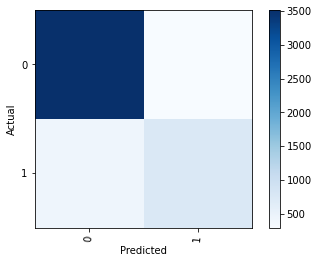

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def _evaluate(model, x_test):
  model.eval()
  x = torch.Tensor(x_test).float()
  predictions = [1 if i>0.5 else 0 for i in model(x).data]
  predictions = torch.tensor(predictions)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()
_evaluate(model, x_test)

* Khởi tạo hệ số theo `xavier`

In [ ]:
model.apply(lambda m: init_weights(m, init_type = 'xavier'))

Model(
  (fc1): Linear(in_features=108, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
loss_criteria = nn.HuberLoss()
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
epoch_nums = []
training_loss = []
validation_loss = []
epochs = 30
for epoch in range(1, epochs + 1):
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.075032
Validation set: Average loss: 0.053806, Accuracy: 4217/5000 (84%)

Epoch: 2
Training set: Average loss: 0.059719
Validation set: Average loss: 0.052484, Accuracy: 4227/5000 (85%)

Epoch: 3
Training set: Average loss: 0.057076
Validation set: Average loss: 0.052050, Accuracy: 4231/5000 (85%)

Epoch: 4
Training set: Average loss: 0.055779
Validation set: Average loss: 0.050920, Accuracy: 4252/5000 (85%)

Epoch: 5
Training set: Average loss: 0.055306
Validation set: Average loss: 0.051486, Accuracy: 4236/5000 (85%)

Epoch: 6
Training set: Average loss: 0.054230
Validation set: Average loss: 0.052607, Accuracy: 4227/5000 (85%)

Epoch: 7
Training set: Average loss: 0.054044
Validation set: Average loss: 0.050276, Accuracy: 4257/5000 (85%)

Epoch: 8
Training set: Average loss: 0.054391
Validation set: Average loss: 0.050997, Accuracy: 4264/5000 (85%)

Epoch: 9
Training set: Average loss: 0.053752
Validation set: Average loss: 0.052327, Accuracy: 

Evaluation on test dataset
ACCURACY_SCORE:  0.8506
F1_SCORE:  0.7729
CONFUSION_MATRIX:
 [[3589  222]
 [ 525  664]] 

              precision    recall  f1-score   support

           0     0.8724    0.9417    0.9057      3811
           1     0.7494    0.5585    0.6400      1189

    accuracy                         0.8506      5000
   macro avg     0.8109    0.7501    0.7729      5000
weighted avg     0.8431    0.8506    0.8425      5000
 



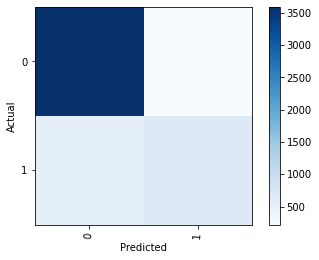

In [ ]:
_evaluate(model, x_test)

Như vậy khởi tạo `he` tốt hơn so với `xavier`

# 9. Thiết lập không gian search và tự động hóa tìm kiếm kiến trúc tốt nhất trên optuna.

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 210 kB 53.9 MB/s 
     |████████████████████████████████| 80 kB 7.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 113 kB 56.8 MB/s 
     |████████████████████████████████| 149 kB 47.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=f72aba7bbd51ccd56ebbffdf35ab5bac39b730b9e1f3de67915a3e9b37cd3a81
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).float()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=32,
    shuffle=True, num_workers=2)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).float()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=32,
    shuffle=False, num_workers=2)
print('Ready to load data')

Ready to load data


Khởi tạo thêm [focal loss](https://arxiv.org/abs/1708.02002). Bài diễn giải về [focal loss](https://phamdinhkhanh.github.io/2020/08/23/FocalLoss.html) tại khanhblog

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs,  targets.float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

Thiết lập kiến trúc mô hình. Tại đây chúng ta search activation layer, số lượng hidden unit trên fully connected layer và thêm batch normalization.

In [ ]:
  def define_model(trial):
      # We optimize the number of layers, hidden units and dropout ratio in each layer.
      n_layers = trial.suggest_int("n_layers", 2, 5)
      layers = []
      act_layers = {
          'relu': nn.ReLU(),
          'sigmoid': nn.Sigmoid(),
          'gelu': nn.GELU(),
      }

      in_features = len(features)
      for i in range(n_layers):
          out_features = trial.suggest_int("n_units_l{}".format(i), 20, 200)
          layers.append(nn.Linear(in_features, out_features))
          layers.append(nn.BatchNorm1d(out_features))
          act_type = trial.suggest_categorical("act_type", ['relu', 'sigmoid', 'gelu'])
          layers.append(act_layers[act_type])
          p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6)
          layers.append(nn.Dropout(p))
          in_features = out_features
      layers.append(nn.Linear(in_features, 1))
      layers.append(nn.Sigmoid())

      return nn.Sequential(*layers)

In [ ]:
DEVICE = torch.device("cpu")
BATCHSIZE = 32
EPOCHS = 30
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 500
N_VALID_EXAMPLES = BATCHSIZE * 100

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    # Generate the loss function
    criteria_name = trial.suggest_categorical("criterial", ['BCELoss', 'HuberLoss', 'FocalLoss'])
    criteria_dict = {
        'BCELoss': nn.BCELoss(),
        'HuberLoss': nn.HuberLoss(),
        'FocalLoss': FocalLoss()
    }
    loss_criteria = criteria_dict[criteria_name]
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_criteria(output, target.reshape(-1,1))
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = torch.tensor(output.data>=0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-18 15:40:06,798] A new study created in memory with name: no-name-d24f8d34-a471-4b9a-ae94-e0b65c8b9efc
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-18 15:41:26,828] Trial 0 finished with value: 0.8521875 and parameters: {'n_layers': 2, 'n_units_l0': 195, 'act_type': 'relu', 'dropout_l0': 0.25296350403450374, 'n_units_l1': 182, 'dropout_l1': 0.5370156829874394, 'optimizer': 'RMSprop', 'lr': 0.0004852477730378687, 'criterial': 'HuberLoss'}. Best is trial 0 with value: 0.8521875.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-18 15:42

Study statistics: 
  Number of finished trials:  57
  Number of pruned trials:  48
  Number of complete trials:  9
Best trial:
  Value:  0.855625
  Params: 
    n_layers: 2
    n_units_l0: 180
    act_type: relu
    dropout_l0: 0.5125618589162688
    n_units_l1: 178
    dropout_l1: 0.21238340147941487
    optimizer: RMSprop
    lr: 0.0027600325214591184
    criterial: HuberLoss


In [ ]:
model = define_model(trial)

In [ ]:
loss_criteria = nn.HuberLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=trial.params['lr'])
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 30 epochs
epochs = 100
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    train_loss = train(model, train_loader, optimizer)
    test_loss = test(model, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.059575
Validation set: Average loss: 0.052688, Accuracy: 4237/5000 (85%)

Epoch: 2
Training set: Average loss: 0.056164
Validation set: Average loss: 0.051859, Accuracy: 4260/5000 (85%)

Epoch: 3
Training set: Average loss: 0.054407
Validation set: Average loss: 0.051026, Accuracy: 4269/5000 (85%)

Epoch: 4
Training set: Average loss: 0.053541
Validation set: Average loss: 0.050150, Accuracy: 4272/5000 (85%)

Epoch: 5
Training set: Average loss: 0.053028
Validation set: Average loss: 0.051482, Accuracy: 4261/5000 (85%)

Epoch: 6
Training set: Average loss: 0.053207
Validation set: Average loss: 0.050089, Accuracy: 4256/5000 (85%)

Epoch: 7
Training set: Average loss: 0.052162
Validation set: Average loss: 0.050293, Accuracy: 4280/5000 (86%)

Epoch: 8
Training set: Average loss: 0.051829
Validation set: Average loss: 0.050116, Accuracy: 4282/5000 (86%)

Epoch: 9
Training set: Average loss: 0.051608
Validation set: Average loss: 0.049354, Accuracy: 

Evaluation on test dataset
ACCURACY_SCORE:  0.853
F1_SCORE:  0.7882
CONFUSION_MATRIX:
 [[3515  296]
 [ 439  750]] 

              precision    recall  f1-score   support

           0     0.8890    0.9223    0.9053      3811
           1     0.7170    0.6308    0.6711      1189

    accuracy                         0.8530      5000
   macro avg     0.8030    0.7766    0.7882      5000
weighted avg     0.8481    0.8530    0.8497      5000
 



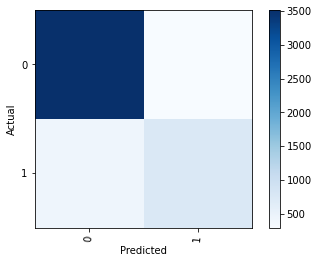

In [ ]:
_evaluate(model, x_test)

### Sử dụng tham số mới thì acc đã tăng lên 0.853

In [ ]:
model_file = 'model.pt'
torch.save(model.state_dict(), model_file)
del model

In [ ]:
_save_pkl('trial.pkl', trial)

In [ ]:
!ls

 4.Homework_Correction.ipynb		 knn_no_scale.pkl
 4.Homework.ipynb			 knn.pkl
 4.Model_Deployment_Flask.ipynb		 model.pt
'4.NeuralNetwork&DeepLearning.gslides'	 scaler.pkl
 4.NeuralNetwork_Practice.ipynb		 trial.pkl
 4.SetupInitializeNeuralNetwork.ipynb


# 10. Deploy model sử dụng flask ap. Tham khảo Flaskapp tutorial.

Tham khảo [model deployment](https://drive.google.com/drive/folders/1AVrCjN5pZo2Jk7wP2J-IGgrpJf0fbDkX?usp=sharing). Trong đó file chính để chạy server là:

`server.py`

```python
from PIL import Image
import numpy as np
from flask import Flask, request
import flask
import json
from utils import define_model, _load_pkl, NumpyEncoder
import torch

# Khởi tạo model.
global model
trial = _load_pkl('trial.pkl')
model = define_model(trial)
model = torch.load('model.pt')
# Khởi tạo flask app
app = Flask(__name__)

# Khai báo các route 1 cho API
@app.route("/", methods=["GET"])
# Khai báo hàm xử lý dữ liệu.
def _hello_world():
  return "Hello world"

# Khai báo các route 2 cho API
@app.route("/predict", methods=["POST"])
# Khai báo hàm xử lý dữ liệu.
def _predict():
  data = {"success": False}
  request_body = request.json
  if request_body:
    x_input = request_body['data']
    print('data: ', x_input)
    x_input = np.random.randn(1, 108)
    # Convert sang numpy array input
    X_input = torch.Tensor(x_input).float()
    # change model into eval mode
    model.eval()
    predict = model(X_input)
    # Dự báo nhãn
    label = [1 if i>0.5 else 0 for i in predict.data]
    # Truyền vào data form response
    data["label"] = label
    data["success"] = True
    return json.dumps(data, ensure_ascii=False, cls=NumpyEncoder)

if __name__ == "__main__":
  print("App run!")
  model_file="model.pt"
  model = define_model(trial)
  model.load_state_dict(torch.load(model_file))
  app.run(debug=False, host='localhost', threaded=False)

```